<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/35_%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%B2_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интеграция нейронной сети в Production. Flask, Spark.

В этом уроке мы создадим учебное web-приложение, которое будет распознавать рукописную цифру, нарисованную мышкой в браузере. Распознаванием будет заниматься нейронная сеть, предварительно обученная на стандартном наборе MNIST.

Мы напишем и обучим 2 функционально одинаковые сети/модели - одну на Keras, другую на PyTorch. 

Далее мы перенесем наши модели на условную production-машину, предназначенную для "промышленной" эксплуатации нашей системы. В качестве production-среды мы будем также использовать colab, возможно другую сессию виртуальной машины. В качестве web-сервера будем использовать тестовый сервер, встроенный в фреймворк Flask. 



## Обучение модели keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


Загружаем стандартный набор MNIST, приводим данные к типу float32 и диапазону от 0 до 1.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Нормализуем значения пикселей (от 0 до 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(x_train.shape, y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


Наша модель будет содержать 2 каскада сверточных слоев и 2 полносвязных слоя классификатора. 

In [ ]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=200, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
300/300 [==============================] - 18s 5ms/step - loss: 0.5376 - accuracy: 0.8281 - val_loss: 0.0500 - val_accuracy: 0.9841
Epoch 2/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 3/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0306 - val_accuracy: 0.9904
Epoch 4/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 5/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0249 - val_accuracy: 0.9913
Epoch 6/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0242 - val_accuracy: 0.9923
Epoch 7/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0273 - val_accuracy: 0.9900
Epoch

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02868933044373989
Test accuracy: 0.9936000108718872


Сделалем описание модели в формате JSON и запишем в его файл:

In [ ]:
model_json = model.to_json() 
with open("model.json", "w") as json_file: 
    json_file.write(model_json)

Отдельно сохраним веса обученной модели:

In [ ]:
model.save_weights("model.h5")

Теперь файлы `model.json` и `model.h5` следует скопировать на production-машину. Но в нашем случае мы будем использовать в качестве production тот же colab. Перенесем файлы на другую виртуальную машину через google-drive:

In [ ]:
!cp model.json model.h5 /content/drive/MyDrive/Models/

## Обучение модели на PyTorch

Создадим аналогичную модель на PyTorch. Особенностью PyTorch является другой порядок следования размерностей в тензоре входных данных - (B, C, H, W)

B - batch, C - color channel, H - height, W - width.

В keras последовательность (B, H, W, C)

In [ ]:
import torch
import torch.onnx as onnx
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import os

Загружаем стандартный набор MNIST из `torchvision.datasets`

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=200)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Flatten(),
            nn.Linear(4*4*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
%%time
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    losses, val_losses = [], []
    for x, y in train_dataloader:
        optimizer.zero_grad()
        logits = model(x.to(device))
        loss = criterion(logits, y.to(device))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    avg_loss = np.array(losses).mean()
    
    for x, y in test_dataloader:
        logits = model(x.to(device))
        loss = criterion(logits, y.to(device))
        val_losses.append(loss.item())
    avg_val_loss = np.array(val_losses).mean()

    print("Epoch %d/%d, loss %.4f, val_loss %.4f" % 
          (epoch+1, epochs, avg_loss, avg_val_loss))

Epoch 1/20, loss 0.2579, val_loss 0.0600
Epoch 2/20, loss 0.0581, val_loss 0.0424
Epoch 3/20, loss 0.0419, val_loss 0.0356
Epoch 4/20, loss 0.0303, val_loss 0.0356
Epoch 5/20, loss 0.0227, val_loss 0.0269
Epoch 6/20, loss 0.0183, val_loss 0.0358
Epoch 7/20, loss 0.0156, val_loss 0.0329
Epoch 8/20, loss 0.0143, val_loss 0.0298
Epoch 9/20, loss 0.0122, val_loss 0.0262
Epoch 10/20, loss 0.0095, val_loss 0.0233
Epoch 11/20, loss 0.0078, val_loss 0.0342
Epoch 12/20, loss 0.0079, val_loss 0.0353
Epoch 13/20, loss 0.0083, val_loss 0.0310
Epoch 14/20, loss 0.0060, val_loss 0.0325
Epoch 15/20, loss 0.0066, val_loss 0.0339
Epoch 16/20, loss 0.0053, val_loss 0.0357
Epoch 17/20, loss 0.0071, val_loss 0.0349
Epoch 18/20, loss 0.0056, val_loss 0.0409
Epoch 19/20, loss 0.0041, val_loss 0.0323
Epoch 20/20, loss 0.0045, val_loss 0.0373
CPU times: user 1min 43s, sys: 6.34 s, total: 1min 49s
Wall time: 1min 49s


Оценим точность на тестовом наборе:

In [ ]:
total, correct = 0, 0
for x, y in test_dataloader:
    logits = model(x.to(device))
    _,pred_t = torch.max(logits, dim=1)
    correct += torch.sum(pred_t == y.to(device)).item()
    total += y.size(0)
test_acc = (100 * correct / total)
print(test_acc)

99.2


Cкопируем веса модели на google-drive

In [ ]:
path = os.path.join('/content/drive/MyDrive/Models', 'model_weights.pth')
torch.save(model.state_dict(), path)

Попробуем восстановить веса модели:

In [ ]:
model.load_state_dict(torch.load(path))
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

Преобразуем модель в формат ONNX и запишем на google-drive:

In [ ]:
path_onnx = os.path.join('/content/drive/MyDrive/Models', 'model.onnx')
input_image = torch.zeros((1, 1, 28, 28))
onnx.export(model.to('cpu'), input_image, path_onnx)

## Flask

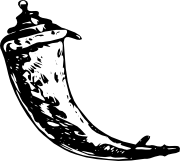
Здесь можно запустить новую сессию (без GPU) для эмуляции работы production-машины



[Flask](https://flask.palletsprojects.com/en/1.1.x/quickstart/) - фреймворк на Python для создания Web-приложений.

Альтернативные фреймворки на Python, решающие те же задачи - [Django](https://www.djangoproject.com/) и [FastAPI](https://fastapi.tiangolo.com/)


Импортируем Flask и создадим простейшее приложение

In [ ]:
from flask import Flask, render_template

app = Flask(__name__)

@app.route('/')
def hello_world():
    # return render_template('index.html')
    return 'Hello, World!'

Декоратор `@app.route(uri)` связывает ссылку, по которой обратились к сайту, с функцией, создающей контент web-страницы.

Существует несколько способов запустить web-приложение (или _сервер_).

Один из них - запустить сервер как отдельный _поток_ (Thread) в текущем процессе. Это можно сделать с помощью пакета `threading`:

In [ ]:
import threading

Запуск сервера в отдельном потоке не заблокирует выполнение ячейки и мы сможем работать дальше.

In [ ]:
threading.Thread(target=app.run, kwargs={'host' : 'localhost', 'port':5001}).start()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:5001/ (Press CTRL+C to quit)


К сожалению, браузер не может соединиться с нашим сервером, так как его IP-адрес нам недоступен.

Можно делать к нему HTTP-запросы из colab-ноутбука, для этого импортируем библиотеку `requests`

In [ ]:
import requests

r = requests.get('http://localhost:5001') 
print(r.status_code) 
print(r.text) 

127.0.0.1 - - [06/May/2021 12:55:11] "GET / HTTP/1.1" 200 -


200
Hello, World!


Существует способ достучаться до сервера извне (например подключиться браузером) - создать туннельный канал. Запускаем сервер еще раз, обычным способом (без отдельного потока). При этом выполнение "зависнет" на этой ячейке.

Для доступа к нашему серверу через браузер можно воспользоваться сервисом https://ngrok.com

На виртуалку colab скачивается выполняемый файл ./ngrok Он создает соединение к облачному сервису и выдает некоторый адрес (типа http://d33d2465ae4f.ngrok.io/ ) при обращении к которому через браузер соединение пробрасывается на наш сервер.

In [ ]:
!wget http://dataudt.ru/datasets/ngrok

--2021-05-06 12:58:12--  http://dataudt.ru/datasets/ngrok
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30048819 (29M) [application/octet-stream]
Saving to: ‘ngrok’

ngrok               100%[===================>]  28.66M  10.3MB/s    in 2.8s    

2021-05-06 12:58:15 (10.3 MB/s) - ‘ngrok’ saved [30048819/30048819]



Сделаем программу исполняемой:

In [ ]:
!chmod +x ngrok

И запустим, указав токен. ( Индивидуальный токен можно получить, создав себе эккаунт на http://ngrok.com)

In [ ]:
!./ngrok authtoken 1P6QIs3hbpbfvjSqiraMWPsPkyP_5KVjgA2niQhCtRRhYZ16D

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


Запускаем программу в фоновом режиме, указав протокол http и порт, на котором слушает наш сервер. Сервис создаст временный адрес (типа 62b167b33830.ngrok.io, каждый раз другой) Соединения по этому адресу будут пробрасываться на запущенную нами программу `ngrok`, она будет соединяться с нашим сервером flask, и возвращать полученные данные назад.

Откройте окно терминала (значок в левом нижнем углу 
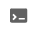
) и наберите в нем 

```
./ngrok http 5000
```




Для соединения с нашим сервером наберите в браузере адрес, который программа выведет в строке Forwarding

Но сначала нам надо загрузить статические файлы нашего приложения 

Загрузим статические файлы для нашего web-приложения flask:

In [ ]:
!wget http://dataudt.ru/datasets/flask-app.tar

--2021-05-06 13:01:57--  http://dataudt.ru/datasets/flask-app.tar
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71680 (70K) [application/octet-stream]
Saving to: ‘flask-app.tar’

flask-app.tar       100%[===================>]  70.00K   202KB/s    in 0.3s    

2021-05-06 13:01:58 (202 KB/s) - ‘flask-app.tar’ saved [71680/71680]



Развернем tar-архив в текущем каталоге 

In [ ]:
!tar xvf flask-app.tar

./
./static/
./static/index.js
./static/jquery-1.3.2.min.js
./static/style.css
./templates/
./templates/index.html


Копируем файлы keras-модели с гугль-драйва в текущий каталог:

In [ ]:
!cp /content/drive/MyDrive/Models/model.json .
!cp /content/drive/MyDrive/Models/model.h5 .

In [ ]:
import tensorflow as tf
import base64

Восстанавливаем модель на production-машине:

In [ ]:
with open('model.json','r') as json_file: 
    loaded_model_json = json_file.read()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Браузер передает изображение, закодировав данные в base64

Нам нужно преобразовать большое изображение (рисунок цифры) в маленькое, размера 28х28. Проще всего это сделать, предварительно записав изображение во временный PNG-файл.

Следующая функция создает png-файл из строки, кодирующей изображение в кодировке base64.

Пример изображения 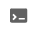 в кодировке base64:
```
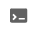
```

In [ ]:
def convertImage(img):
    imgstr = re.search(b'base64,(.*)', img).group(1)
    with open('output.png','wb') as output: # временный файл, в который записываем декодированное представление
        output.write(base64.b64decode(imgstr))

Это - наше приложение на Flask. По адресу `/` (или `/index`) выводится страница изображения с холстом (canvas) для рисования цифры.

После нажатия кнопки 'predict' браузер посылает на сервер AJAX-запрос по адресу `/predict`. В качестве данных передается изображение в кодировке base64.

Наш сервер преобразует полученное изображение в 28х28 и запускает модель на инференс. Полученный результат (с указанием вероятности) возвращается в качестве ответа на AJAX-запрос и далее выводится на странице.

In [ ]:
from flask import Flask, request, render_template
from tensorflow.keras.preprocessing import image
import numpy as np

app = Flask(__name__)

@app.route('/')
@app.route('/index')
def index():
    return render_template("index.html") # темплейты берутся из каталога templates

# здесь будут обрабатываться AJAX-запросы на распознавание цифры
@app.route('/predict/', methods=['GET','POST'])
def predict():
    imgData = request.get_data()
    convertImage(imgData) # сохраняем во временный файл output.png
    img = image.load_img('output.png', target_size=(28, 28), color_mode='grayscale')
    x = np.array(img)
    x = np.reshape(x, (1, 28, 28, 1))
    x = 1. - (x / 255.) 
    pred = loaded_model.predict(x) 
    digit = np.argmax(pred, axis=1)[0] 
    prob = pred[0, digit]             
    print(pred, digit) # для отладки (вывод в консоль)
    # response = np.array_str(np.argmax(pred, axis=1))
    response = '%d probability:%.3f' % (digit, prob)
    return response

Запустим приложение flask и обратимся в браузере по 'Forwarding' адресу 

In [ ]:
import os
import re

port = int(os.environ.get('PORT', 5000))
app.run(host='localhost', port=port, debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://localhost:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/May/2021 13:34:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2021 13:34:14] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2021 13:34:14] "GET /static/index.js HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2021 13:34:16] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/May/2021 13:34:43] "POST /predict/ HTTP/1.1" 200 -


[[1.3294101e-14 1.4366061e-08 4.5992310e-10 1.0000000e+00 1.0833263e-15
  4.8259230e-10 4.0969239e-15 1.4971000e-08 1.6183874e-11 1.3820094e-10]] 3


127.0.0.1 - - [06/May/2021 13:36:58] "POST /predict/ HTTP/1.1" 200 -


[[2.2975580e-11 2.3307811e-11 2.5664759e-08 6.4565298e-11 7.1991296e-10
  9.8250842e-01 1.7491469e-02 6.4578711e-15 4.4080077e-09 1.9708644e-09]] 5


127.0.0.1 - - [06/May/2021 13:37:10] "POST /predict/ HTTP/1.1" 200 -


[[3.1745204e-11 5.1176247e-10 7.9859556e-06 4.8909622e-04 6.2073805e-06
  2.1953246e-01 3.7739440e-11 1.3293447e-06 1.7587039e-06 7.7996117e-01]] 9


127.0.0.1 - - [06/May/2021 13:37:20] "POST /predict/ HTTP/1.1" 200 -


[[6.8168600e-12 3.0626893e-11 3.6857063e-08 1.2181085e-09 2.1857035e-13
  1.0322259e-11 1.8257074e-14 7.2653559e-13 1.0000000e+00 3.9674063e-08]] 8


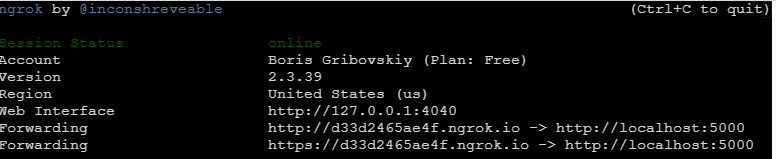

Connect to http://dc6416ab25a1.ngrok.io/ - измените эту ссылку на адрес в строке Forwarding

Пример работы:

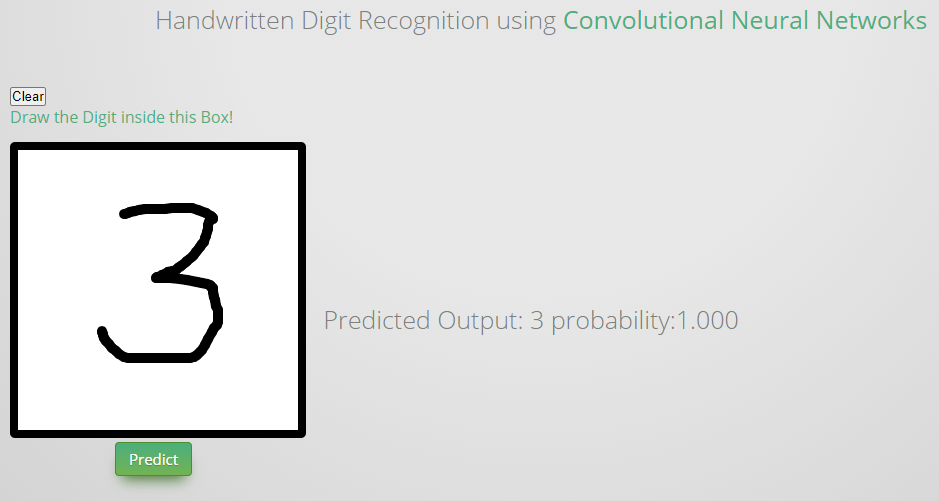

# ONNX

В предыдущем примере мы запустили на production модель, созданную с помощью keras и восстановленную из ее описания в формате JSON. Иногда такой подход неудобен или невозможен, например если у нас используется несколько моделей, созданных в разных фреймворках.

Возможное решение этой проблемы - использование [ONNX](https://onnx.ai/)

**ONNX** (Open Neural Network Exchange) — открытая библиотека программного обеспечения для построения нейронных сетей глубокого обучения. С помощью ONNX ИИ-разработчики могут обмениваться моделями между различными инструментами и выбирать наилучшую комбинацию этих инструментов. ONNX разрабатывается и поддерживается совместно компаниями Microsoft, Facebook, Amazon и другими партнерами как проект с открытым исходным кодом

### ONNX - Keras model
Запустим нашу модель, используя ONNX.

In [ ]:
!pip install keras2onnx
!pip install onnxruntime
!pip install tensorflow==2.3 # keras2onnx не работает с 2.4

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 460kB 25.7MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import keras2onnx
import onnxruntime
import tensorflow as tf
import numpy as np
import onnx
import os

print(tf.__version__)

2.3.0


Восстановим нашу keras-модель

In [ ]:
!cp /content/drive/MyDrive/Models/model.json .
!cp /content/drive/MyDrive/Models/model.h5 .

In [ ]:
with open('model.json','r') as json_file: 
    model_json = json_file.read()

model = tf.keras.models.model_from_json(model_json)
model.load_weights("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Преобразуем модель в формат ONNX:

In [ ]:
onnx_model = keras2onnx.convert_keras(model, model.name) # дает ошибку в TF2.4, нужен TF2.3!

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 35 -> 19


Для запуска ONNX-моделей в режиме инференса создаем сессию:

In [ ]:
content = onnx_model.SerializeToString() # сериализуем
sess = onnxruntime.InferenceSession(content)

In [ ]:
for i in sess.get_inputs():
    print(i)

NodeArg(name='conv2d_input', type='tensor(float)', shape=['N', 28, 28, 1])


Сделаем инференс на случайных данных.

In [ ]:
x = np.random.rand(1, 28, 28, 1).astype(np.float32)

Входные данные подаются в виде словаря

In [ ]:
feed = dict([(inputs.name, x) for inputs in sess.get_inputs()])

In [ ]:
pred = sess.run(None, feed)

In [ ]:
pred

[array([[2.2342063e-02, 5.8534769e-03, 7.9906702e-01, 4.0213138e-02,
         3.1601463e-03, 4.0129609e-02, 1.9426116e-03, 6.1314105e-04,
         7.7469327e-02, 9.2094438e-03]], dtype=float32)]

In [ ]:
def convertImage(img):
    imgstr = re.search(b'base64,(.*)', img).group(1)
    with open('output.png','wb') as output: # временный файл, в который записываем декодированное представление
        output.write(base64.b64decode(imgstr))

In [ ]:
from flask import Flask, request, render_template
from tensorflow.keras.preprocessing import image
import numpy as np
import base64

app = Flask(__name__)
content = onnx_model.SerializeToString() # сериализуем
sess = onnxruntime.InferenceSession(content)

@app.route('/')
@app.route('/index')
def index():
    return render_template("index.html") # темплейты берутся из каталога templates

# здесь будут обрабатываться AJAX-запросы на распознавание цифры
@app.route('/predict/', methods=['GET','POST'])
def predict():
    imgData = request.get_data()
    convertImage(imgData) # сохраняем во временный файл output.png
    img = image.load_img('output.png', target_size=(28, 28), color_mode='grayscale')
    x = np.array(img)
    x = np.reshape(x, (1, 28, 28, 1))
    x = 1. - (x / 255.) 
    x = x.astype(np.float32)
    feed = dict([(inputs.name, x) for inputs in sess.get_inputs()])
    pred = sess.run(None, feed)[0]
    digit = np.argmax(pred, axis=1)[0] 
    prob = pred[0, digit]             
    print(pred, digit) # для отладки (вывод в консоль)
    response = '%d probability:%.3f' % (digit, prob)
    return response


In [ ]:
import os
import re

port = int(os.environ.get('PORT', 5000))
app.run(host='localhost', port=port, debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://localhost:5000/ (Press CTRL+C to quit)


тестируйте приложение.

### ONNX - PyTorch model

Повторим тоо же самое, заменив модель на pytorch.

In [ ]:
!pip install onnxruntime
!pip install onnx

     |████████████████████████████████| 12.2MB 12.0MB/s 


In [ ]:
import onnx
import onnxruntime
import tensorflow as tf  # только для конвертации картинки
import numpy as np
import os

print(tf.__version__)

2.4.1


In [ ]:
!wget http://dataudt.ru/datasets/ngrok
!chmod +x ./ngrok

--2021-05-06 15:05:51--  http://dataudt.ru/datasets/ngrok
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30048819 (29M) [application/octet-stream]
Saving to: ‘ngrok’

ngrok               100%[===================>]  28.66M  11.4MB/s    in 2.5s    

2021-05-06 15:05:54 (11.4 MB/s) - ‘ngrok’ saved [30048819/30048819]



In [ ]:
!wget http://dataudt.ru/datasets/flask-app.tar
!tar xvf flask-app.tar

--2021-05-06 15:09:10--  http://dataudt.ru/datasets/flask-app.tar
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71680 (70K) [application/octet-stream]
Saving to: ‘flask-app.tar’

flask-app.tar       100%[===================>]  70.00K   280KB/s    in 0.3s    

2021-05-06 15:09:11 (280 KB/s) - ‘flask-app.tar’ saved [71680/71680]

./
./static/
./static/index.js
./static/jquery-1.3.2.min.js
./static/style.css
./templates/
./templates/index.html


In [ ]:
path_onnx = os.path.join('/content/drive/MyDrive/Models', 'model.onnx')
onnx_model = onnx.load(path_onnx)

In [ ]:
def convertImage(img):
    imgstr = re.search(b'base64,(.*)', img).group(1)
    with open('output.png','wb') as output: # временный файл, в который записываем декодированное представление
        output.write(base64.b64decode(imgstr))

In [ ]:
from flask import Flask, request, render_template
from tensorflow.keras.preprocessing import image
import numpy as np
import base64
from scipy.special import softmax

app = Flask(__name__)
content = onnx_model.SerializeToString() 
sess = onnxruntime.InferenceSession(content)

@app.route('/')
@app.route('/index')
def index():
    return render_template("index.html") # темплейты берутся из каталога templates

# здесь будут обрабатываться AJAX-запросы на распознавание цифры
@app.route('/predict/', methods=['GET','POST'])
def predict():
    imgData = request.get_data()
    convertImage(imgData) # сохраняем во временный файл output.png
    img = image.load_img('output.png', target_size=(28, 28), color_mode='grayscale')
    x = np.array(img)
    x = np.reshape(x, (1, 1, 28, 28))
    x = 1. - (x / 255.) 
    x = x.astype(np.float32)
    feed = dict([(inputs.name, x) for inputs in sess.get_inputs()])
    logits = sess.run(None, feed)[0]
    digit = np.argmax(logits, axis=1)[0] 
    prob = softmax(logits, axis=1)[0, digit]             
    print(digit, prob) # для отладки (вывод в консоль)
    response = '%d probability:%.3f' % (digit, prob)
    return response

In [ ]:
import os
import re

port = int(os.environ.get('PORT', 5000))
app.run(host='localhost', port=port, debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://localhost:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/May/2021 15:31:24] "POST /predict/ HTTP/1.1" 200 -


3 1.0


127.0.0.1 - - [06/May/2021 15:31:40] "POST /predict/ HTTP/1.1" 200 -


5 0.9983515


127.0.0.1 - - [06/May/2021 15:32:02] "POST /predict/ HTTP/1.1" 200 -


5 0.52905726


127.0.0.1 - - [06/May/2021 15:32:10] "POST /predict/ HTTP/1.1" 200 -


7 0.98818284


127.0.0.1 - - [06/May/2021 15:32:17] "POST /predict/ HTTP/1.1" 200 -


8 1.0


127.0.0.1 - - [06/May/2021 15:32:24] "POST /predict/ HTTP/1.1" 200 -


0 0.9194368


127.0.0.1 - - [06/May/2021 15:32:31] "POST /predict/ HTTP/1.1" 200 -


1 0.9999934


127.0.0.1 - - [06/May/2021 15:32:36] "POST /predict/ HTTP/1.1" 200 -


1 0.99984926


127.0.0.1 - - [06/May/2021 15:32:38] "POST /predict/ HTTP/1.1" 200 -


1 0.99984926


127.0.0.1 - - [06/May/2021 15:32:43] "POST /predict/ HTTP/1.1" 200 -


2 1.0


127.0.0.1 - - [06/May/2021 15:32:50] "POST /predict/ HTTP/1.1" 200 -


2 0.99995995


127.0.0.1 - - [06/May/2021 15:32:59] "POST /predict/ HTTP/1.1" 200 -


4 0.99371034


127.0.0.1 - - [06/May/2021 15:33:09] "POST /predict/ HTTP/1.1" 200 -


8 0.99993706


127.0.0.1 - - [06/May/2021 15:33:18] "POST /predict/ HTTP/1.1" 200 -


2 0.6764632


127.0.0.1 - - [06/May/2021 15:33:28] "POST /predict/ HTTP/1.1" 200 -


9 0.892513


[Приложение](http://6589a2665ab9.ngrok.io) - отредактируйте адрес

# TensorFlow Serving

Это еще один вариант для запуска моделей в production.

### SavedModel формат

Давайте посмотрим, как запустить нашу keras-модель в среде TensorFlow Serving.

Прежде всего мы должны преобразовать нашу модель в специальный формат, т.н. [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model)

Восстановим модель по ее JSON описанию и сохраненным весам:

In [ ]:
import os
import tensorflow as tf
import json

In [ ]:
gdir = '/content/drive/MyDrive/Models'
path_h5 = os.path.join(gdir, 'model.h5')
path_json = os.path.join(gdir, 'model.json')

with open(path_json,'r') as json_file: 
    model_json = json_file.read()

model = tf.keras.models.model_from_json(model_json)
model.load_weights(path_h5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Так выполняется преобразование модели в формат `SavedModel`. Подробнее об аргументах можно прочесть [здесь](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model) 

Можно записать несколько версий модели, каждую свой подкаталог. 

In [ ]:
MODEL_DIR = '/content/mnist'
version = 1  
export_path = os.path.join(MODEL_DIR, str(version)) 
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format='tf', 
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}
print('Путь для экспорта = {}\n'.format(export_path))

INFO:tensorflow:Assets written to: /content/mnist/1/assets

Сохраненная модель:
total 148
drwxr-xr-x 2 root root   4096 May  9 07:25 assets
-rw-r--r-- 1 root root 139656 May  9 10:21 saved_model.pb
drwxr-xr-x 2 root root   4096 May  9 10:21 variables
Путь для экспорта = /content/mnist/1



Модели в формате `SavedModel` могут быть проанализированы утилитой `saved_model_cli`.

In [ ]:
!saved_model_cli show --dir {export_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0509 10:25:50.678425 140267244488576 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pyt

Есть и другие команды, позволяющие инспектировать и запускать модели.

In [ ]:
!saved_model_cli -h


usage: saved_model_cli [-h] [-v] {show,run,scan,convert} ...

saved_model_cli: Command-line interface for SavedModel

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  valid commands

  {show,run,scan,convert}
                        additional help


Подробнее об утилите `saved_model_cli` можно прочесть [здесь](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface)

Для удобства переноса на другую машину запишем каталог с моделью (или с версиями модели) в сжатый tar-архив

In [ ]:
!tar cvfz tfs_model.tgz mnist

mnist/
mnist/1/
mnist/1/assets/
mnist/1/variables/
mnist/1/variables/variables.data-00000-of-00001
mnist/1/variables/variables.index
mnist/1/saved_model.pb


Считаем набор данных MNIST для тестирования результатов работы модели в среде TF Serving

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Нормализуем значения пикселей до интервала от 0 до 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Приводим к виду 4D тензора
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

Создадим тестовые данные из 3-х картинок в виде JSON-файла. 

In [ ]:
data = {"signature_name": "serving_default", "instances": test_images[:3].tolist()}
with open("data_mnist.json", "w") as write_file:
    json.dump(data, write_file)

### Docker

Удобно запускать сервис TF Serving как контейнер Docker.
Есть готовые образы, которые могут быть скачаны:
```
# Download the TensorFlow Serving Docker image and repo
docker pull tensorflow/serving
```
Это приведет к загрузке минимального образа Docker с установленным TensorFlow Serving. 

**Запуск образа Docker для обслуживания**

Обслуживающие образы (как CPU, так и GPU) имеют следующие свойства: 
* Порт 8500 открыт для gRPC 
* Порт 8501 доступен для REST API 
* Необязательная переменная среды MODEL_NAME (по умолчанию `model`) 
* Необязательная переменная среды MODEL_BASE_PATH (по умолчанию `/models`) 

Обслуживающий сервис запускается следующим образом:
```
docker run -p 8501:8501 --mount type=bind,source=путь,target=/models/<имя_модели> -e MODEL_NAME=<имя_модели> -t tensorflow/serving
```


Пример запроса к сервису:
```
curl -X POST -H "Content-Type: application/json" -d @data_mnist.json http://host.domain:8501/v1/models/модель:predict
```

# Apache Spark

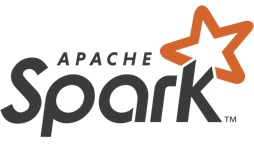

Зачастую данных бывает так много, или они поступают так быстро, что один компьютер не может справиться. В таких случаях прибегают к _распределенным_ вычислениям, когда данные располагаются на _нодах_ (nodes) _кластера_ и вычисления делаются параллельно, одновременно на многих компьютерах.

Для распределенных вычислений требуется специализированное программное обеспечение. Apache Spark как раз и является примером такого ПО.



[Spark](https://spark.apache.org/) – это проект Apache, который позиционируется как инструмент для «молниеносных кластерных вычислений». Spark предоставляет быструю и универсальную платформу для обработки Big Data. Spark применяется во многих крупнейших компаниях, таких, как Amazon, eBay и Yahoo! Многие организации эксплуатируют Spark в кластерах, включающих тысячи узлов. 

Spark написан на языке Scala.

Есть готовая интерактивная оболочка (REPL). При помощи REPL можно протестировать результат выполнения каждой строки кода без необходимости сначала программировать и выполнять все задание целиком.

Spark имеет следующие ключевые черты:

* В настоящее время предоставляет API для Scala, Java и Python, также готовится поддержка других языков (например, R)
* Хорошо интегрируется с экосистемой Hadoop и источниками данных (HDFS, Amazon S3, Hive, HBase, Cassandra, etc.)
* Может работать на кластерах под управлением Hadoop YARN или Apache Mesos, а также работать в автономном режиме

Ядро Spark дополняется набором мощных высокоуровневых библиотек, которые бесшовно стыкуются с ним в рамках того же приложения. В настоящее время к таким библиотекам относятся SparkSQL, Spark Streaming, MLlib (для машинного обучения) и GraphX

В Spark есть 3 API для работы с распределенными по узлам кластера данными:

**RRD**

Устойчивый распределенный набор данных (Resilient Distributed Dataset, RDD) RDD был основным пользовательским API в Spark с момента его создания. RDD - это неизменяемая распределенная коллекция элементов данных, распределенная по узлам в кластере. С данными можно работать параллельно через низкоуровневый API.

**DataFrames**

Как и RDD, DataFrame представляет собой неизменяемую распределенную коллекцию данных. В отличие от RDD, данные организованы в именованные столбцы, как таблица в реляционной базе данных. DataFrame, разработанный для упрощения обработки больших наборов данных, позволяет разработчикам накладывать структуру на распределенный набор данных, обеспечивая абстракцию на более высоком уровне; он предоставляет специфичный для предметной области языковой API для управления распределенными данными.

**Datasets**

Datasets - третий API для работы с данными. Он подразумевает строгую типизацию данных, как в языке Java. Python не поддерживает строгую типизацию, поэтому при работе с ним лучше использовать API DataFrame или RRD, если требуется больший контроль.

Spark состоит из 4-х основных компонентов:

**SparkSQL**

[SparkSQL](https://spark.apache.org/sql/) – это компонент Spark, поддерживающий запрашивание данных либо при помощи SQL, либо посредством Hive Query Language.

**Spark Streaming**

[Spark Streaming](https://spark.apache.org/streaming/) поддерживает обработку потоковых данных в реальном времени; такими данными могут быть файлы логов рабочего веб-сервера (напр. Apache Flume и HDFS/S3), информация из соцсетей, например, Twitter, а также различные очереди сообщений вроде Kafka. «Под капотом» Spark Streaming получает входные потоки данных и разбивает данные на пакеты. Далее они обрабатываются движком Spark, после чего генерируется конечный поток данных (также в пакетной форме)

**MLlib**

[MLlib](https://spark.apache.org/mllib/) – это библиотека для машинного обучения, предоставляющая различные алгоритмы, разработанные для горизонтального масштабирования на кластере в целях классификации, регрессии, кластеризации, совместной фильтрации и т.д. Некоторые из этих алгоритмов работают и с потоковыми данными — например, линейная регрессия с использованием обычного метода наименьших квадратов или кластеризация по методу k-средних (список вскоре расширится).

**GraphX**

[GraphX](https://spark.apache.org/graphx/) – это библиотека для манипуляций над графами и выполнения с ними параллельных операций. Библиотека предоставляет универсальный инструмент для ETL, исследовательского анализа и итерационных вычислений на основе графов. Кроме встроенных операций для манипуляций над графами здесь также предоставляется библиотека обычных алгоритмов для работы с графами, например, PageRank.

### Установка
[источник](https://towardsdatascience.com/a-neanderthals-guide-to-apache-spark-in-python-9ef1f156d427)

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init() 

Вычисления в Spark делаются в контексте _сессий_. Пример создания сессии с именем 'spark':
(Более подробно см. [Builder API](https://spark.apache.org/docs/2.2.0/api/java/index.html?org/apache/spark/sql/SparkSession.Builder.html) )

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

### SparkSQL

В качестве примера возьмем данные по продажам видеоигр с [Kaggle](https://www.kaggle.com/gregorut/videogamesales)

In [ ]:
!wget http://dataudt.ru/datasets/vgsales.csv

--2021-05-07 15:43:20--  http://dataudt.ru/datasets/vgsales.csv
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1355781 (1.3M) [application/octet-stream]
Saving to: ‘vgsales.csv’

vgsales.csv         100%[===================>]   1.29M  1.74MB/s    in 0.7s    

2021-05-07 15:43:21 (1.74 MB/s) - ‘vgsales.csv’ saved [1355781/1355781]



Считываем данные из CSV файла в дата фрейм Spark:

In [ ]:
data = spark.read.csv('vgsales.csv', inferSchema=True, header=True)

Датафреймы Spark аналогичны датафреймам Pandas, названия многих методов совпадают, но поведение может отличаться. Более подробно об отличиях можно прочитать в [статье](https://medium.com/@chris_bour/6-differences-between-pandas-and-spark-dataframes-1380cec394d2) 

In [ ]:
data

DataFrame[Rank: int, Name: string, Platform: string, Year: string, Genre: string, Publisher: string, NA_Sales: double, EU_Sales: double, JP_Sales: double, Other_Sales: double, Global_Sales: double]

Выведем число строк и столбцов:

In [ ]:
data.count(), len(data.columns)

(16598, 11)

Выведем первые 5 строк (если не указывать число строк, выводится 20)

In [ ]:
data.show(5)

+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|   11.27|    8.89|   10.22|        1.0|       31.37|
+----+--------------------+--------+----+------------+---------+

Структура датафрейма описываются _схемой_

In [ ]:
data.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)



Можно вывести только указанные столбцы

In [ ]:
data.select("Name", "Platform", "Genre", "Publisher").show(15, truncate=False)

+---------------------------+--------+------------+---------+
|Name                       |Platform|Genre       |Publisher|
+---------------------------+--------+------------+---------+
|Wii Sports                 |Wii     |Sports      |Nintendo |
|Super Mario Bros.          |NES     |Platform    |Nintendo |
|Mario Kart Wii             |Wii     |Racing      |Nintendo |
|Wii Sports Resort          |Wii     |Sports      |Nintendo |
|Pokemon Red/Pokemon Blue   |GB      |Role-Playing|Nintendo |
|Tetris                     |GB      |Puzzle      |Nintendo |
|New Super Mario Bros.      |DS      |Platform    |Nintendo |
|Wii Play                   |Wii     |Misc        |Nintendo |
|New Super Mario Bros. Wii  |Wii     |Platform    |Nintendo |
|Duck Hunt                  |NES     |Shooter     |Nintendo |
|Nintendogs                 |DS      |Simulation  |Nintendo |
|Mario Kart DS              |DS      |Racing      |Nintendo |
|Pokemon Gold/Pokemon Silver|GB      |Role-Playing|Nintendo |
|Wii Fit

Применяем фильтр к набору данных. 

Это эквивалентно `SQL select Name, Global_Sales from data where Global_Sales > 20 order by Global_Sales desc limit 5` 

In [ ]:

data.select("Name", "Global_Sales").where('Global_Sales > 20').orderBy("Global_Sales", ascending=False).show(5) 

+--------------------+------------+
|                Name|Global_Sales|
+--------------------+------------+
|          Wii Sports|       82.74|
|   Super Mario Bros.|       40.24|
|      Mario Kart Wii|       35.82|
|   Wii Sports Resort|        33.0|
|Pokemon Red/Pokem...|       31.37|
+--------------------+------------+
only showing top 5 rows



Есть возможность вывести статистические показатели по интересующим столбцам:

In [ ]:
data.describe(["NA_Sales", "Global_Sales"]).show()

+-------+-------------------+------------------+
|summary|           NA_Sales|      Global_Sales|
+-------+-------------------+------------------+
|  count|              16598|             16598|
|   mean|0.26466742981084057|  0.53744065550074|
| stddev| 0.8166830292988798|1.5550279355699066|
|    min|                0.0|              0.01|
|    max|              41.49|             82.74|
+-------+-------------------+------------------+



Пример операции groupBy (в данном случае - для подсчета количества вхождений)

In [ ]:
data.groupBy("Platform") \
.count() \
.orderBy("count", ascending=False) \
.show(10)

+--------+-----+
|Platform|count|
+--------+-----+
|      DS| 2163|
|     PS2| 2161|
|     PS3| 1329|
|     Wii| 1325|
|    X360| 1265|
|     PSP| 1213|
|      PS| 1196|
|      PC|  960|
|      XB|  824|
|     GBA|  822|
+--------+-----+
only showing top 10 rows



Поддерживаются параллельнные вычисления и партиционирование данных.

В качестве примера вычислим число $\pi$ методом Монте-Карло. Возьмем большое число случайных точек в квадрате со стророной 1 и вычислим долю точек, попавших в круг единичного радиуса, у которых расстояние до точки (0, 0) меньше 1.

In [ ]:
partitions = 2
n = 1000000 * partitions

In [ ]:
from random import random

def f(_):
    x = random() 
    y = random()
    return 1 if x ** 2 + y ** 2 <= 1 else 0

В данном примере вычисление функции `f(_)` распараллеливается на несколько _partitions_ и результаты вычислений _аггрегируются_ (суммируются в данном случае)

In [ ]:
%%time
from operator import add

count = spark.sparkContext.parallelize(range(n), partitions).map(f).reduce(add)
print("Pi is roughly %f" % (4.0 * count / n))

Pi is roughly 3.140796
CPU times: user 25.4 ms, sys: 2.8 ms, total: 28.2 ms
Wall time: 1.72 s


#End